In [1]:
import sys
from pathlib import Path
import copy

import numpy as np
import matplotlib.pyplot as plt

REPO_ROOT = Path(".").resolve().parent
print(REPO_ROOT)
sys.path.append(REPO_ROOT.as_posix())

from limap_extension.constants import CAM_INTRINSIC
from limap_extension.img_cloud_transforms import imgs_to_clouds_np, cloud_to_img_np, reproject_img
# from img_cloud_transforms import imgs_to_clouds_np, cloud_to_img_np
# from scripts.transforms_spatial import
# from tests.test_utils import read_test_data
from test_utils import read_test_data

# %matplotlib ipympl
%load_ext autoreload
%autoreload 2

/home/dcolli23/code/LIMap-Extension


In [2]:
td_1, td_2 = read_test_data()

In [3]:
img_1_in_frame_2, valid_bbox = reproject_img(td_1.rgb,
                                             td_1.depth,
                                             td_1.pose,
                                             td_2.pose,
                                             interpolation_method="clough_tocher")

In [4]:
11 * 700 * 2 * 5 / 60 / 60


21.38888888888889

In [5]:
# valid_bbox
# coord_bounds

# To do this right, I shoudl probably send the four coordinates of the image corners through the
# projection/reprojection pipeline and then discern the rectangular bounds from those.


In [6]:
# img_1_in_frame_2.shape

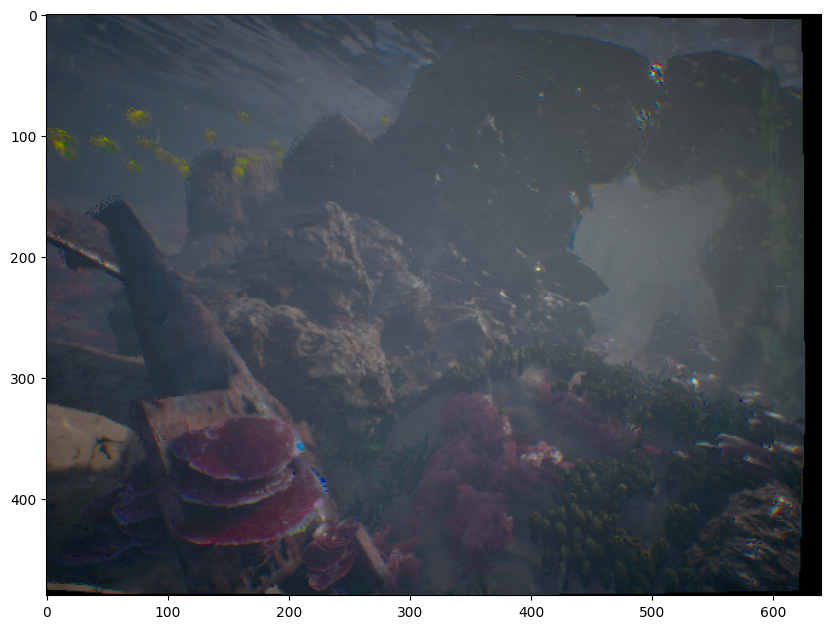

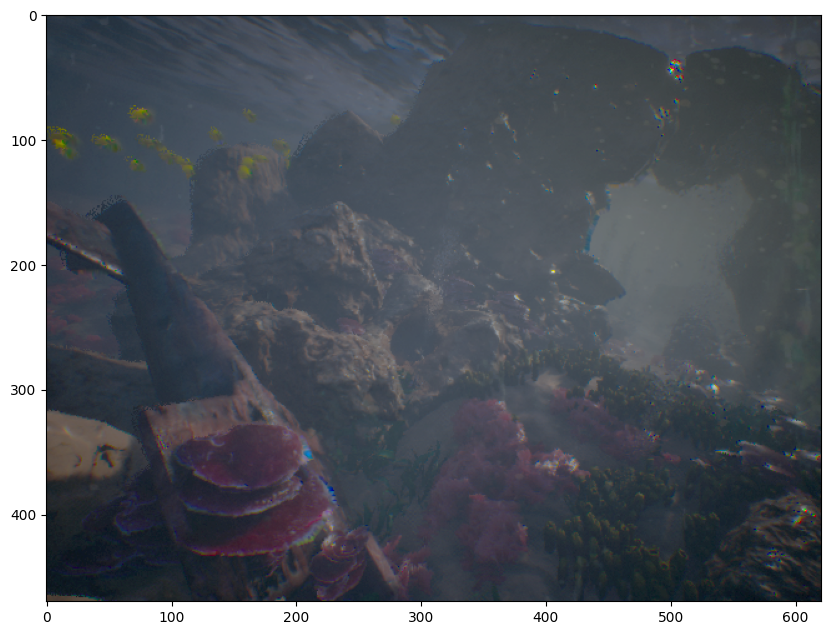

In [7]:
def show_img(img: np.ndarray):
    plt.figure(figsize=[10, 10])
    plt.imshow(img)


show_img(img_1_in_frame_2)
show_img(valid_bbox.crop_img(img_1_in_frame_2))

[[ 0.39867657 -0.48341653]
 [ 0.31663531 -0.38851161]
 [-0.04657235 -0.19748454]
 [-0.2680996  -0.0794969 ]
 [ 0.36230307 -0.15079802]
 [ 0.10805217  0.02145262]
 [ 0.15501138 -0.2701214 ]
 [ 0.40970984 -0.3710429 ]
 [ 0.47998049 -0.24779184]
 [-0.04249337 -0.21607701]]
(10,)


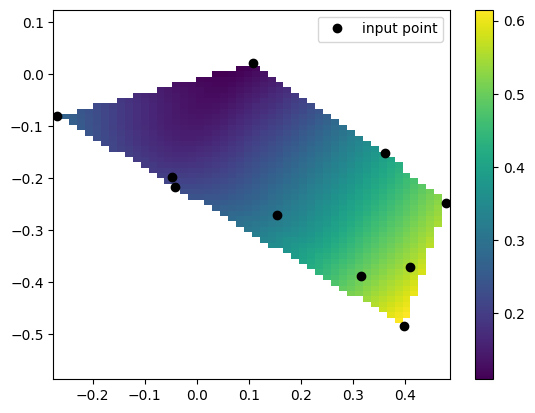

In [8]:
from scipy.interpolate import CloughTocher2DInterpolator
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()
x = rng.random(10) - 0.5
y = rng.random(10) - 0.5
z = np.hypot(x, y)
X = np.linspace(min(x), max(x))
Y = np.linspace(min(y), max(y))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
data_locs = np.asarray(list(zip(x, y)))
print(data_locs)
print(z.shape)
interp = CloughTocher2DInterpolator(data_locs, z)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto')
plt.plot(x, y, "ok", label="input point")
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()

In [9]:
from scripts.img_cloud_transforms import transform_cloud, get_uv_coords

rgb_1 = td_1.rgb
depth_1 = td_1.depth
pose_1 = td_1.pose
pose_2 = td_2.pose

cloud_frame_1, corner_idxs = imgs_to_clouds_np(rgb_1, depth_1, CAM_INTRINSIC)
H_1_2 = np.linalg.inv(pose_1) @ pose_2
cloud_tformed = transform_cloud(cloud_frame_1, H_1_2)
# img_tformed, valid_bbox = cloud_to_img_np(cloud_tformed, CAM_INTRINSIC, corner_idxs=corner_idxs)

In [10]:
intrinsic = CAM_INTRINSIC
cloud = cloud_tformed
depth_units_to_tracked_units = 1.0
img_height = 480
img_width = 640

fx = intrinsic[0, 0]
fy = intrinsic[1, 1]

center_x = intrinsic[0, 2]
center_y = intrinsic[1, 2]

constant_x = 1.0 / fx
constant_y = 1.0 / fy

xs = cloud.xyz[:, 0]
ys = cloud.xyz[:, 1]
zs = cloud.xyz[:, 2] / depth_units_to_tracked_units

vs = xs / (zs * depth_units_to_tracked_units * constant_x) + center_x
us = ys / (zs * depth_units_to_tracked_units * constant_y) + center_y

uv_coords = np.round(np.stack((us, vs), axis=0)).astype(int)

# If no corner indexes are provided, the valid bounding box is the entire image.
valid_bbox = np.array(((0, img_height), (0, img_width)), dtype=int)
if corner_idxs is not None:
    # If corner indexes are provided, we can use them to get a tighter bounding box on what
    # parts of image 1 are visible in image 2. This should help the flow out.
    UPPER_LEFT_IDX = corner_idxs[0]
    UPPER_RIGHT_IDX = corner_idxs[1]
    LOWER_LEFT_IDX = corner_idxs[2]
    LOWER_RIGHT_IDX = corner_idxs[3]

    # yapf: disable
    x_min_bound = np.max([
        uv_coords[0, UPPER_LEFT_IDX],
        uv_coords[0, UPPER_RIGHT_IDX],
        0
    ])
    x_max_bound = np.min([
        uv_coords[0, LOWER_LEFT_IDX],
        uv_coords[0, LOWER_RIGHT_IDX],
        img_height
    ])
    y_min_bound = np.max([
        uv_coords[1, UPPER_LEFT_IDX],
        uv_coords[1, LOWER_LEFT_IDX],
        0
    ])
    y_max_bound = np.min([
        uv_coords[1, UPPER_RIGHT_IDX],
        uv_coords[1, LOWER_RIGHT_IDX],
        img_width
    ])
    # yapf: enable

    valid_bbox = np.array(((x_min_bound, x_max_bound), (y_min_bound, y_max_bound)), dtype=int)

where_u_valid = np.logical_and(uv_coords[0] >= 0, uv_coords[0] < img_height)
where_v_valid = np.logical_and(uv_coords[1] >= 0, uv_coords[1] < img_width)
where_uv_valid = np.logical_and(where_u_valid, where_v_valid)

uv_coords = uv_coords[:, where_uv_valid]
rgb_valid = cloud.rgb[where_uv_valid, :]

In [11]:
uv_coords = uv_coords.T

In [12]:
from scipy.interpolate import CloughTocher2DInterpolator

In [13]:
rgb_float = rgb_valid.astype(float)

In [14]:
# U, V = np.meshgrid(np.arange(img_height), np.arange(img_width))
U, V = get_uv_coords(img_height, img_width)
uv_coords_interp = np.stack((V.flatten(), U.flatten()), axis=1)
print(uv_coords_interp.shape)

(307200, 2)


In [ ]:
interp = CloughTocher2DInterpolator(uv_coords, rgb_float[:, 0])
# interp.
# interp.values

: 

In [18]:
# img = np.zeros((img_height, img_width, 3), dtype=np.uint8)
channels = []
interp = CloughTocher2DInterpolator(uv_coords, rgb_valid[:, 0])
for i in range(3):
    # for i in range(1):
    channel = interp(uv_coords_interp)
    channels.append(channel.reshape((img_height, img_width)))
    interp.values = np.array(rgb_valid[:, i + 1][:, None].astype(np.float64))

IndexError: index 3 is out of bounds for axis 1 with size 3

/tmp/ipykernel_658486/2293573740.py:1: RuntimeWarning: invalid value encountered in cast
  img = np.stack(channels, axis=2).astype(np.uint8)


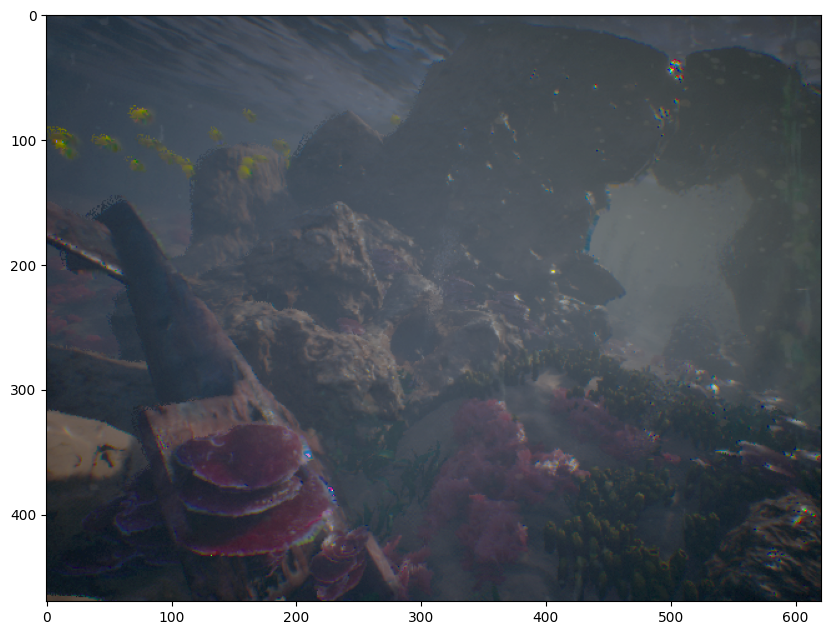

In [38]:
img = np.stack(channels, axis=2).astype(np.uint8)

show_img(img[valid_bbox[0, 0]:valid_bbox[0, 1], valid_bbox[1, 0]:valid_bbox[1, 1], :])

# channels[0].shape

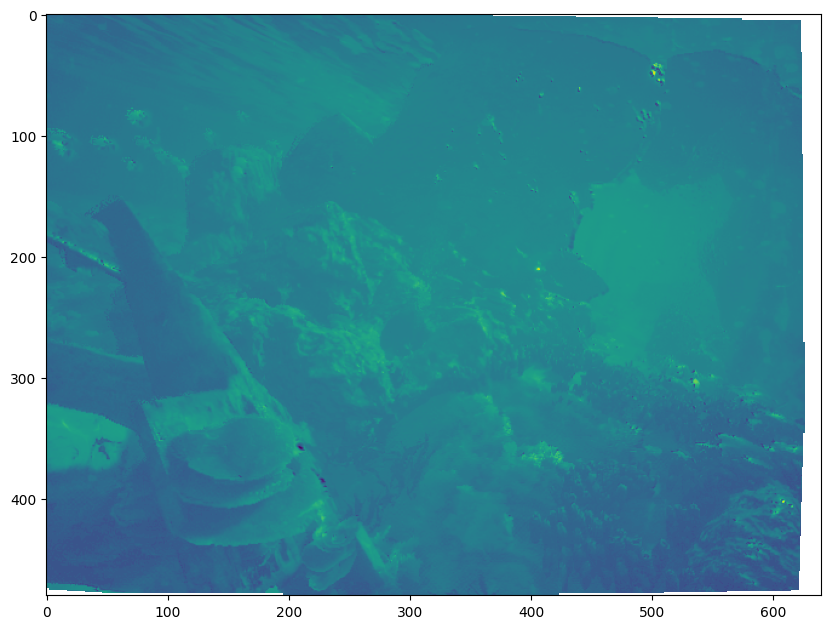

In [34]:
show_img(channels[0])